# Laboratory 8:  Solution of the Quasi-geostrophic Equations using an Implicit Scheme #
## Lin Yang & John M. Stockie ##


## 1. Objectives ##

This lab is an introduction to the use of implicit schemes for the
solution of PDE’s, using as an example the quasi-geostrophic equations
that govern the large-scale circulation of the oceans.

You will see that the discretization of the governing equations leads to
a large, sparse system of linear equations. The resulting matrix problem
is solved with relaxation methods, one of which you will write the code
for, by modifying the simpler Jacobi relaxation. There are two types of
boundary conditions typically used for this problem, one of which you
will program yourself – your computations are easily compared to
previously-obtained “classical” results.

## 2. Readings ##
There are no required readings for this lab. If you would like some
additional background beyond the material in the lab itself, then you
may refer to the references listed below:

-   **Equations of motion:**

    -   Pedlosky @pedlosky, Sections 4.6 & 4.11 (derivation of QG
        equations)

-   **Nonlinear instability:**

    -   Mesinger & Arakawa @mesinger-arakawa (classic paper with
        description of instability and aliasing)

    -   Arakawa & Lamb @arakawa-lamb (non-linear instability in the QG
        equations, with the Arakawa-Jacobian)

-   **Numerical methods:**

    -   Susan Allen’s course notes (nice description of relaxation)

    -   Strang @strang-linalg (analysis of implicit schemes)

    -   McCalpin: @mccalpin (<span>FWEB</span> code for QGbox model,
        with <span>*extensive*</span> documentation on numerical
        details)

-   **Classical numerical results:**

    -   Veronis @veronis (numerical results)

    -   Bryan @bryan (numerical results)


In [1]:
from IPython.display import Image

## 3. Introduction ##

An important aspect in the study of large-scale circulation in the ocean
is the response of the ocean to wind stress. Solution of this problem
using the full Navier-Stokes equations is quite complicated, and it is
natural to look for some way to simplify the governing equations. A
common simplification in many models of large-scale, wind-driven ocean
circulation, is to assume a system that is homogeneous and barotropic.

It is now natural to ask:

> *Does the simplified model capture the important dynamics in the
> real ocean?*

This question can be investigated by solving the equations numerically,
and comparing the results to observations in the real ocean. Many
numerical results are already available, and so the purpose of this lab
is to introduce you to the numerical methods used to solve this problem,
and to compare the computed results to those from some classical papers
on numerical ocean simulations.

Some of the numerical details (in Sections [lab8:sec:discretef],
[lab8:sec:boundary], [lab8:sec:matrix], [lab8:sec:relax] and the
appendices are quite technical, and may be passed over the first time
you read through the lab. You can get a general idea of the basic
solution procedure without them. However, you should return to them
later and understand the material contained in them, since these
sections contain techniques that are commonly encountered when solving
PDE’s, and an understanding of these sections is required for you to
answer the problems in the Lab.


## 4. The Quasi-Geostrophic Model ##

Consider a rectangular ocean with a flat bottom, as pictured in
[Figure Model Ocean](#Figure-Model-Ocean), and ignore curvature effects, by confining the region of interest to a *mid-latitude $\beta$-plane*.

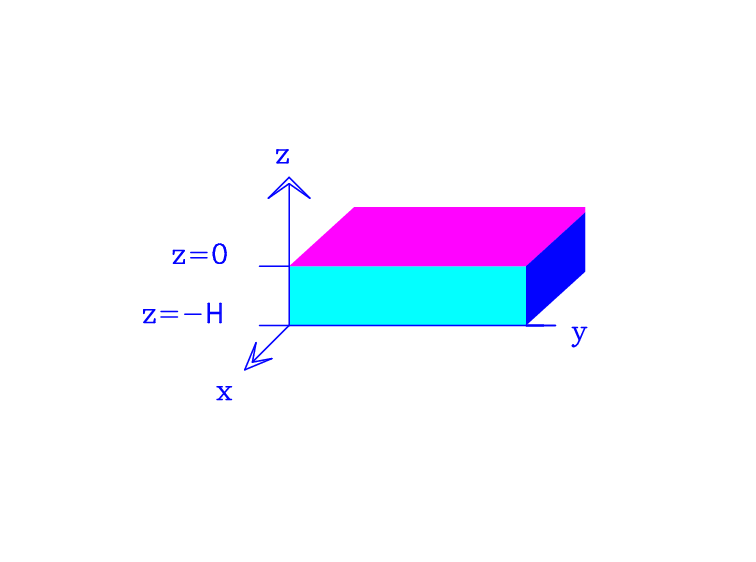

In [4]:
Image(filename='images/rect.png',width='45%') 

<div id='Figure-Model-Ocean'>
**Figure Model Ocean.** The rectangular ocean with flat bottom, ignoring curvature
effects.
</div>

More information on what is a $\beta$-plane and on the neglect of
curvature terms in the $\beta$-plane approximation is given in the
appendix.

If we assume that the ocean is homogeneous (it has constant density
throughout), then the equations governing the fluid motion on the
$\beta$-plane are: 

<div id='eq:xmom'>
(X-Momentum Eqn)
$$
  \frac {\partial u}{\partial t} + u \frac {\partial u}{\partial x} + v \frac {\partial u}{\partial y} + w \frac{\partial u}{\partial z} - fv = - \, \frac{1}{\rho} \, \frac {\partial p}{\partial x}
  + A_v \, \frac{\partial^2 u}{\partial z^2} + A_h \, \nabla^2 u
$$</div>
<div id ='eq:ymom'>
(Y-Momentum Eqn)
$$
  \frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} + w \frac{\partial v}{\partial z} + fu = - \, \frac{1}{\rho} \, \frac{\partial p}{\partial y}
  + A_v \, \frac{\partial^2 v}{\partial z^2} + A_h \, \nabla^2 v
$$</div>
<div id ='eq:hydrostatic'>
$$\frac{\partial p}{\partial z} = - \rho g$$
</div>
<div id ='eq:continuity'>
(Continuity Eqn)
$$\frac {\partial u}{\partial x} + \frac{\partial v}{\partial y} = - \, \frac{\partial w}{\partial z}$$ </div>

where

-   ([X-Momentum Eqn](#eq:xmom)) and ([Y-Momentum Eqn](#eq:ymom)) are the lateral momentum equations,

-   ([Hydrostatic Eqn](#eq:hydrostatic)) is the hydrostatic balance (and replaces the vertical momentum
    equation), and

-   ([Continuity Eqn](#eq:continuity)) is the continuity (or incompressibility or conservation of volume) condition.

The variables and parameters appearing above are:

-   $(u,v,w)$, the fluid velocity components;

-   $f(y)$, the Coriolis parameter (assumed to be a linear function of
    $y$);

-   $\rho$, the density (assumed constant for a homogeneous fluid);

-   $A_v$ and $A_h$, the vertical and horizontal coefficients of
    viscosity, respectively (constants);

-   $g$, the gravitational acceleration (constant).

Equations - form a non-linear system of PDE’s, for which there are many
numerical methods available. However, due to the complexity of the
equations, the methods themselves are *very complex*, and
consume a large amount of CPU time. It is therefore advantageous for us
to reduce the equations to a simpler form, for which common, and more
efficient numerical solution techniques can be used.


By applying a sequence of physically-motivated approximations (see
Appendix), and by using the boundary conditions, the system - can be
reduced to a single PDE: 
<div id='eq:quasi'>
$$
  \frac{\partial}{\partial t} \, \nabla_h^2 \psi + {\cal J} \left( \psi, \nabla_h^2 \psi \right)
  + \beta \, \frac {\partial \psi}{\partial x} = \frac{1}{\rho H} \, \nabla_h \times \tau - \kappa
  \, \nabla_h^2 \psi + A_h \, \nabla_h^4 \psi $$
</div>  
  where

-   $\psi$ is the stream function, defined by
    ${\displaystyle u = - \, \frac{\partial \psi}{\partial y} \, , \, v = \frac{\partial
          \psi}{\partial x}}$;

-   ${\displaystyle \nabla_h = \left(\frac{\partial}{\partial
          x},\frac{\partial}{\partial y}\right)}$ is the “horizontal”
    gradient operator, so-called because it involves only derivatives in
    $x$ and $y$;

-   ${\displaystyle {\cal J} (a,b) = \frac{\partial a}{\partial x} \, \frac{\partial
          b}{\partial y} - \frac{\partial a}{\partial y} \, \frac{\partial b}{\partial x}}$ is the
    <span>*Jacobian*</span> operator;

-   $\vec{\tau}(x,y) = \left(\,\tau_1(x,y),\tau_2(x,y)\,\right)$ is the
    wind stress boundary condition at the surface $z=0$. A simple form
    of the wind stress might assume an ocean “box” that extends from
    near the equator to a latitude of about $60^\circ$, for which
    typical winds are easterly near the equator and turn westerly at
    middle latitudes. A simple function describing this is
    $$\vec{\tau} = \tau_{max} (-\cos y, 0),$$ which is what we will use
    in this lab. 
    
    More complicated wind stress functions are possible. See McCalpin’s
    <span>QGBOX</span> documentation @mccalpin [p. 24] for another
    example.

-   $\beta = df/dy$ is a constant, where $f(y) = f_0+\beta y$ (see
    Appendix[lab8:ap:beta-plane];

-   ${\displaystyle \kappa = \frac{1}{H}  \left( \frac{A_v f_0}{2}
        \right)^{1/2}}$ is the bottom friction scaling (constant); and

-   $H$ is the vertical depth of the water column (constant).

Notice that the original (second order) system of four equations in four
unknowns ($u$, $v$, $w$, $p$) has now been reduced to a single (fourth
order) PDE in one unknown function, $\psi$. It will become clear in the
next section just how much simpler the system of equations has become …

Before going on, though, we need to close the system with the
<span>*boundary conditions*</span> for the stream function $\psi$. We
must actually consider two cases, based on whether or not the lateral
eddy viscosity parameter, $A_h$, is zero:

-   <span>**if $A_h=0$:**</span> the boundary conditions are
    <span>*free-slip*</span>; that is, $\psi=0$ on the boundary.

-   <span>**if $A_h\neq 0$:**</span> the boundary conditions are
    <span>*no-slip*</span>; that is both $\psi$ and its normal
    derivative $\nabla\psi\cdot\hat{n}$ are zero on the boundary (where
    $\hat{n}$ is the normal vector to the boundary).

### 4.1 Scaling the Equations of Motion ###

In physical problems, it is not uncommon for some of the quantities of
interest to differ in size by many orders of magnitude. This is of
particular concern when computing numerical solutions to such problems,
since then round-off errors can begin to pollute the computations (see
Lab 2).

This is also the case for the QG equations, where the parameters have a
large variation in size. The QG model parameters, and typical numerical
values, are given in Table [lab8:tab:parameters].

**Problem Parameters**

| Symbol       | Name                        | Range of Magnitude                            | Units              |
| :----------: | :-------------------------: | :---------------------------------------: | :----------------: |
|   $R$        | Earth’s radius              | $6.4 \times 10^6$                         |  $m$               |
|$\Omega$      | Angular frequency for Earth | $7.27 \times 10^{-5}$                     | $s^{-1}$           |
|   $H$        | Depth of active layer       | $100 \rightarrow 4000$                    |  $m$               |
| $B$          | Length and width of ocean   | $1.0 \rightarrow 5.0 \times 10^6$         | $m$                |
| $\rho$       | Density of water            | $10^3$                                    | $kg/m^3$           |
| $A_h$        | Lateral eddy viscosity      | $0$ or $10^1 \rightarrow 10^4$            | $m^2/s$            |
| $A_v$        | Vertical eddy viscosity     | $10^{-4} \rightarrow 10^{-1}$             | $m^2/s$            |
| $\tau_{max}$ | Maximum wind stress         | $10^{-2} \rightarrow 1$                   | $kg m^{-1} s^{-2}$ |
| $\theta_0$   | Latitude                    | $0 \rightarrow \frac{\pi}{3}$             | -                  |

**Derived Quantities**

| Symbol       | Name                                          | Range of Magnitude                         | Units              |
| :----------: | :-------------------------------------------: | :----------------------------------------: | :----------------: |
| $\beta$      | $\beta =2\Omega \cos \theta_0 / R$            | $1.1 \rightarrow 2.3 \times 10^{-11}$ | $m^{-1} s^{-1}$    |
| $f_0$        | $f_0 = 2 \Omega \sin \theta_0$                | $0.0 \rightarrow 1.3 \times 10^{-4}$  | $s^{-1}$           |
| $U_0$        | Velocity scale = $\tau_{max}/(\beta\rho H B)$ | $10^{-5} \rightarrow 10^{-1}$         | $m s^{-1}$  | 
| $\kappa$     | bottom friction parameter                     | $0.0 \rightarrow 10^{-5}$             | $m^2 s^{-2}$  |

**Non-dimensional Quantities**

| Symbol / Name                                          | Range of Magnitude for Quantity              |
| :----------------------------------------------------: | :------------------------------------------: |
| $\epsilon$ / Vorticity ratio = $U_0/(\beta B^2)$       | (computed)                                   | 
| $\frac{\tau_{max}}{\epsilon\beta^2 \rho H B^3}$        | $10^{-12} \rightarrow 10^{-14}$              |
| $\frac{\kappa}{\beta B}$                               | $4 \times 10^{-4} \rightarrow 6 \times 10^1$ |
| $\frac{A_h}{\beta B^3}$                                | $10^{-7} \rightarrow 10^{-4}$                |

For such problems it is customary to <span>*rescale*</span> the
variables in such a way that the size differences are minimized.

Let us go through this scaling process for the evolution
equation [lab8:eq:quasi] for the stream function, which is reproduced
here for easy comparison:
$$\frac{\partial}{\partial t} \nabla^2_h \psi = 
  - \, \beta \frac{\partial \psi}{\partial x}
  - {\cal J}(\psi, \nabla_h^2\psi)
  + \frac{1}{\rho H} \nabla_h \times \vec{\tau}
  - \kappa \nabla_h^2 \psi
  + A_h \nabla_h^4 \psi$$ The basic idea is to find typical
<span>*scales of motion*</span>, and then redefine the dependent and
independent variables in terms of these scales to obtain
<span>*dimensionless variables*</span>.

For example, the basin width and length, $B$, can be used as a scale for
the dependent variables $x$ and $y$. Then, we define dimensionless
variables 
<div id='eq:xscale'>
(x-scale eqn)
$$x^\prime = \frac{x}{B}$$
</div><div id='eq:yscale'>
(y-scale eqn)
$$y^\prime = \frac{y}{B}$$
</div>

Notice that where $x$ and $y$ varied between
0 and $B$ (where $B$ could be on the order of hundreds of kilometres),
the new variables $x^\prime$ and $y^\prime$ now vary between 0 and 1
(and so the ocean is now a unit square).

Similarly, we can redefine the remaining variables in the problem as
<div id='eq:tscale'>
(t-scale eqn)
$$
  t^\prime = \frac{t}{\left(\frac{1}{\beta B}\right)} $$
</div><div id='eq:psiscale'>
($\psi$-scale eqn)
$$  \psi^\prime = \frac{\psi}{\epsilon \beta B^3} $$
</div><div id='eq:tauscale'>
($\tau$-scale eqn)
$$  \vec{\tau}^\prime = \frac{\vec{\tau}}{\tau_{max}}
  $$</div>

where the scales have been
specially chosen to represent typical sizes of the variables. Here, the
parameter $\epsilon$ is a measure of the the ratio between the “relative
vorticity” ($\max|\nabla_h^2 \psi|$) and the planetary vorticity (given
by $\beta B$).


Now, we need only substitute for the original variables in the
equations, and replace derivatives with their dimensionless
counterparts; for example, using the chain rule,
$$\frac{\partial}{\partial x} = \frac{\partial x^\prime}{\partial x}
\frac{\partial}{\partial x^\prime}.$$ Then the equation of motion
becomes 
<div id='eq:qg-rescaled'>
(Rescaled Quasi-Geostrophic Eqn)
$$
  \frac{\partial}{\partial
    t^\prime} \nabla^{\prime 2}_h \psi^\prime =  
  - \, \frac{\partial \psi^\prime}{\partial x^\prime} 
  - \epsilon {\cal J^\prime}(\psi^\prime,
  \nabla_h^{\prime 2}\psi^\prime) 
  + \frac{\tau_{max}}{\epsilon \beta^2 \rho H B^3} \nabla^\prime_h
  \times \vec{\tau}^\prime 
   - \, \frac{\kappa}{\beta B} \nabla_h^{\prime 2} \psi^\prime
  + \frac{A_h}{\beta B^3} \nabla_h^{\prime 4} \psi^\prime 
  $$ 
</div>  
  The superscript
“$\,^\prime$” on $\nabla_h$ and ${\cal J}$ signify that the derivatives
are taken with respect to the dimensionless variables. Notice that each
term in ([Rescaled Quasi-Geostrophic Eqn](#eq:qg-rescaled)) is now dimensionless, and that there are
now 4 dimensionless combinations of parameters $$\epsilon, \;\; 
\frac{\tau_{max}}{\epsilon \beta^2 \rho H B^3}, \;\;
\frac{\kappa}{\beta B}, \;\; \mbox{ and} \;\;
\frac{A_h}{\beta B^3}.$$ These four expressions define four new
dimensionless parameters that replace the original (unscaled) parameters
in the problem.

The terms in the equation now involve the dimensionless stream function,
$\psi^\prime$, and its derivatives, which have been scaled so that they
are now of order 1 in magnitude. The differences in sizes between terms
in the equation are now embodied solely in the four dimensionless
parameters. A term which is multiplied by a small parameter is thus
truly small in comparison to the other terms, and hence additive
round-off errors will not contribute substantially to a numerical
solution based on this form of the equations.

For the remainder of this lab, we will use the scaled version of the
equations. Consequently, the notation will be simplified by dropping the
“primes” on the dimensionless variables. But, **do not
forget**, that any solution (numerical or analytical) from the
scaled equations must be converted back into dimensional variables
using [the scale equations](#eq:xscale).

## 5. Discretization of the QG equations ##

At first glance, it is probably not clear how one might discretize the
QG equation from the previous section. This equation is an evolution
equation for $\nabla_h^2 \psi$ (the Laplacian of the stream function)
but has a right hand side that depends not only on $\nabla_h^2 \psi$,
but also on $\psi$ and $\nabla_h^4 \psi$. The problem may be written in
a more suggestive form, by letting $\chi = \partial\psi/\partial t$.
Then, equation becomes 
<div id='eq:poisson'>
$$\nabla_h^2 \chi = F(x,y,t), 
$$</div> 

where $F(x,y,t)$ contains all of the terms
except the time derivative. We will see that the discrete version of
this equation is easily solved for the new unknown variable $\chi$,
after which 
<div id='eq:dpsidt'>
$$\frac{\partial\psi}{\partial t} = \chi
$$</div>

may be used to evolve the stream function in
time.

The next two sections discuss the spatial and temporal discretization,
including some details related to the right hand side, the boundary
conditions, and the iterative scheme for solving the large sparse system
of equations that arises from the Poisson equation for $\chi$. Following
that is an summary of the steps in the solution procedure.



# 5.1 Spatial Discretization #

Assume that we are dealing with a square ocean, with dimensions
$1\times 1$ (in non-dimensional coordinates) and begin by dividing the
domain into a grid of discrete points
$$x_i = i \Delta x, \;\;i = 0, 1, 2, \dots, M$$
$$y_j = j \Delta y, \;\;j = 0, 1, 2, \dots, N$$ where $\Delta x = 1/M$
and $\Delta y = 1/N$. In order to simplify the discrete equations, it
will be helpful to assume that $M=N$, so that
$\Delta x = \Delta y \equiv d$. We can then look for approximate values
of the stream function at the discrete points; that is, we look for
$$\Psi_{i,j} \approx \psi(x_i,y_j)$$ (and similarly for $\chi_{i,j}$).
The computational grid and placement of unknowns is pictured in
Figure [Spatial Grid](#Spatial-Grid).

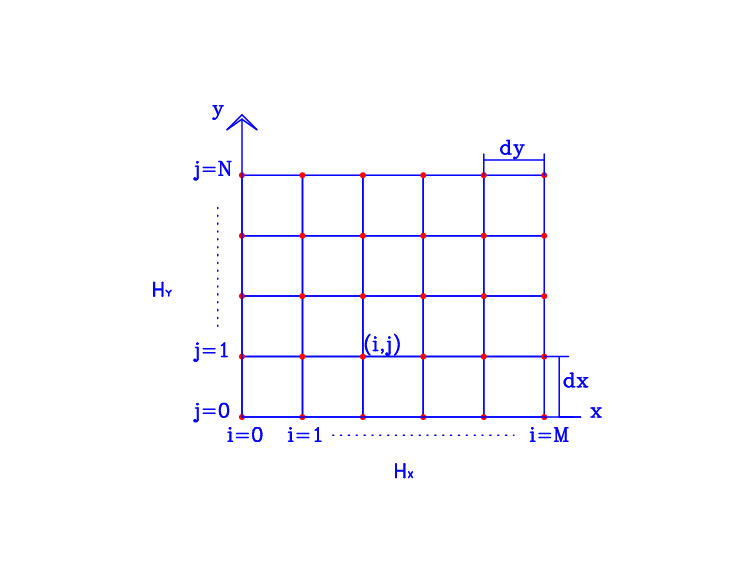

In [6]:
Image(filename='images/spatial.png',width='45%') 

<div id='Spatial-Grid'>
**Figure Spatial Grid**
</div>

Derivatives are replaced by their centered, second-order finite
difference approximations 
$$
  \left. \frac{\partial \Psi}{\partial x} \right|_{i,j}
  \approx 
  \frac{\Psi_{i+1,j}-\Psi_{i-1,j}}{2d}
%%  + {\cal O}(d^2) 
  \left. \frac{\partial^2 \Psi}{\partial x^2} \right|_{i,j} 
  \approx
  \frac{\Psi_{i+1,j} - 2 \Psi_{i,j} + \Psi_{i-1,j}}{d^2}
%%  + {\cal O}(d^2) $$ 
and similarly for the
$y$-derivatives. The discrete analogue of the Poisson equation ,
centered at the point $(x_i,y_j)$, may be written as
$$\frac{\chi_{i+1,j} - 2\chi_{i,j} +\chi_{i-1,j}}{d^2} + 
  \frac{\chi_{i,j+1} - 2\chi_{i,j} +\chi_{i,j-1}}{d^2}  = F_{i,j}$$ or,
after rearranging,
<div id='eq:discrete-chi'>
(Discrete $\chi$ Eqn)
$$\chi_{i+1,j}+\chi_{i-1,j}+\chi_{i,j+1}+\chi_{i,j-1}-4\chi_{i,j} =
  d^2F_{i,j}.
$$</div>

Here, we’ve used
$F_{i,j} = F(x_i,y_j,t)$ as the values of the right hand side function
at the discrete points, and said nothing of how to discretize $F$ (this
will be left until Section [lab8:sec:discretef]). The discrete Poisson
equation is an equation centered at the grid point $(i,j)$, and relating
the values of the approximate solution, $\chi_{i,j}$, at the $(i,j)$
point, to the four neighbouring values, as described by the *5-point difference stencil* pictured in
[Figure Stencil](#fig:stencil]).

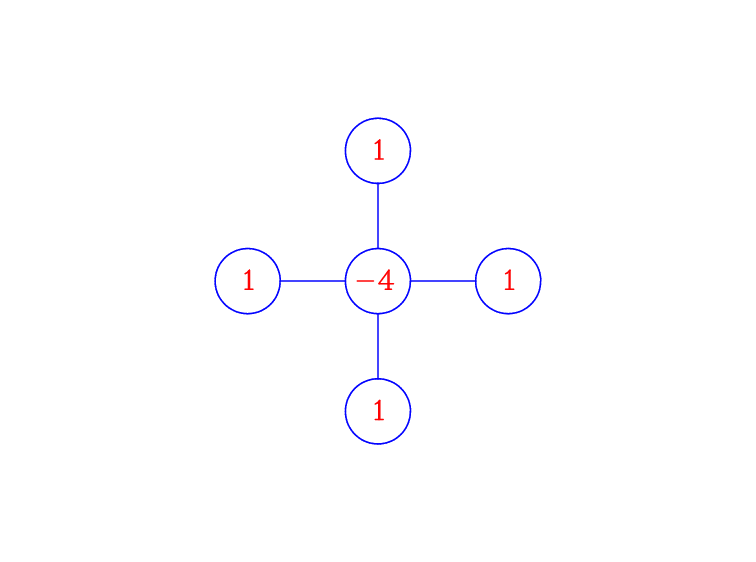

In [8]:
Image(filename='images/2diff.png',width='40%') 